In [21]:
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

sns.set()

## Import preprocessed data

In [18]:
df = pd.read_csv(join('..', 'data', 'tugas_preprocessed.csv'))

In [ ]:
df.head()

In [3]:
df.columns

Index(['income', 'frq', 'rcn', 'clothes', 'kitchen', 'small_appliances',
       'toys', 'house_keeping', 'per_net_purchase', 'spent_online',
       'x0_2nd Cycle', 'x0_Graduation', 'x0_Master', 'x0_PhD', 'x1_Married',
       'x1_Single', 'x1_Together', 'x1_Widow', 'x2_M', 'x3_1.0',
       'x4_Kind of OK', 'x4_Meh...', 'x4_OK nice!', 'x4_Take my money!!',
       'PC0', 'PC1', 'PC2'],
      dtype='object')

In [19]:
# Splitting feature names into groups
non_metric_features = df.columns[df.columns.str.startswith('x')]
pc_features = df.columns[df.columns.str.startswith('PC')]
metric_features = df.columns[~df.columns.str.startswith('x') & ~df.columns.str.startswith('PC')]

## K-Means Clustering
What is K-Means clustering? How does it work?

### How is it computed?
![](../figures/kmeans.png)

### Characteristics:
- *Number of clusters* need to be set apriori
- One of the *fastest* clustering algorithms
- The results *depend on the initialization* (stochastic)
- Prone to *local optima*
- Favors *convex* (round shape) and *isotropic* (same shape) clusters

### How to apply K-Means clustering?

In [6]:
kmclust = KMeans(n_clusters = 5, init='random',n_init=1,random_state=0)
# the fit method
kmclust.fit(df[metric_features])

KMeans(init='random', n_clusters=5, n_init=1, random_state=0)

In [7]:
# the predict method
kmclust.predict(df[metric_features])

array([4, 4, 2, ..., 0, 4, 3])

In [8]:
# the transform method
kmclust.transform(df[metric_features])

array([[3.58919061, 3.96452369, 4.96291039, 3.17797405, 1.23989489],
       [4.54449992, 4.00787175, 6.13665075, 3.4915168 , 2.28286548],
       [3.3098507 , 4.42961936, 2.64125449, 5.63744197, 5.06424299],
       ...,
       [2.19304576, 2.47884232, 3.76009315, 4.10014174, 4.16718658],
       [2.90306842, 3.39822433, 4.08691685, 3.01632531, 2.31300778],
       [5.86038291, 5.09678882, 7.02021518, 2.60703201, 4.00638396]])

In [9]:
np.argmin(kmclust.transform(df[metric_features]),axis=1)

array([4, 4, 2, ..., 0, 4, 3], dtype=int64)

### How can we improve the initialization step?

In [10]:
# Better initialization method and provide more n_init
kmclust = KMeans(n_clusters=8, init='k-means++', n_init=15, random_state=1)
kmclust.fit(df[metric_features])

KMeans(n_init=15, random_state=1)

In [11]:
kmclust.predict(df[metric_features])

array([4, 4, 7, ..., 6, 2, 0])

*init='k-means++'* initializes the centroids to be (generally) distant from each other, leading to probably better results than random initialization. *n_init=K* allows to initialize KMeans K times and pick the best clustering in terms of Inertia. This can been shown in the link below.

**Empirical evaluation of the impact of k-means initialization:**

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_stability_low_dim_dense.html#sphx-glr-auto-examples-cluster-plot-kmeans-stability-low-dim-dense-py

### Defining the number of clusters:

In [12]:
range_clusters = range(1, 11)

In [13]:
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust =  KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df[metric_features])
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

**Inertia (within-cluster sum-of-squares distance) Formula:**
$$\sum_{j=0}^{C}\sum_{i=0}^{n_j}(||x_i - \mu_j||^2)$$
, where:

$C$: Set of identified clusters.

$n_j$: Set of observations belonging to cluster $j$.

$x_i$: Observation $i$.

$\mu_j$: Centroid of cluster $j$.

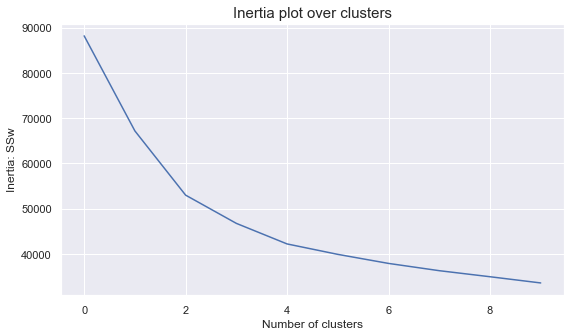

In [14]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

**Silhouette Coefficient formula for a single sample:**
$$s = \frac{b - a}{max(a, b)}$$
, where:
- $a$: The mean distance between a sample and all other points in the same cluster.
- $b$: The mean distance between a sample and all other points in the next nearest cluster

For n_clusters = 2, the average silhouette_score is : 0.2216925624241448
For n_clusters = 3, the average silhouette_score is : 0.23707766584584286
For n_clusters = 4, the average silhouette_score is : 0.21036821905415626
For n_clusters = 5, the average silhouette_score is : 0.19514283937028068
For n_clusters = 6, the average silhouette_score is : 0.18736793579734382
For n_clusters = 7, the average silhouette_score is : 0.16983500681630878
For n_clusters = 8, the average silhouette_score is : 0.16670886503251847
For n_clusters = 9, the average silhouette_score is : 0.1549596056099329
For n_clusters = 10, the average silhouette_score is : 0.15066928575504182


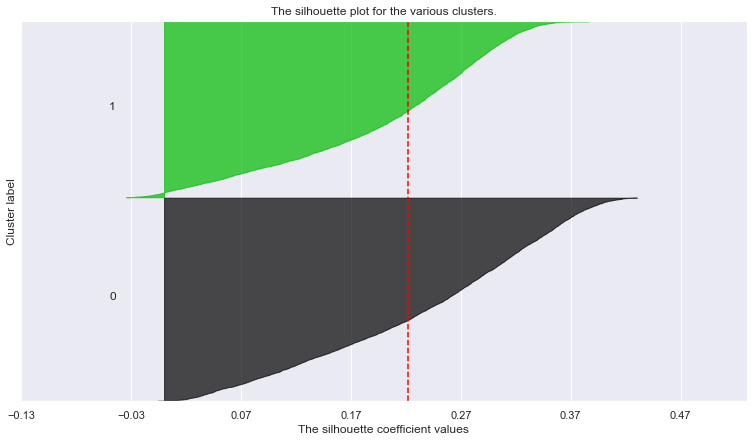

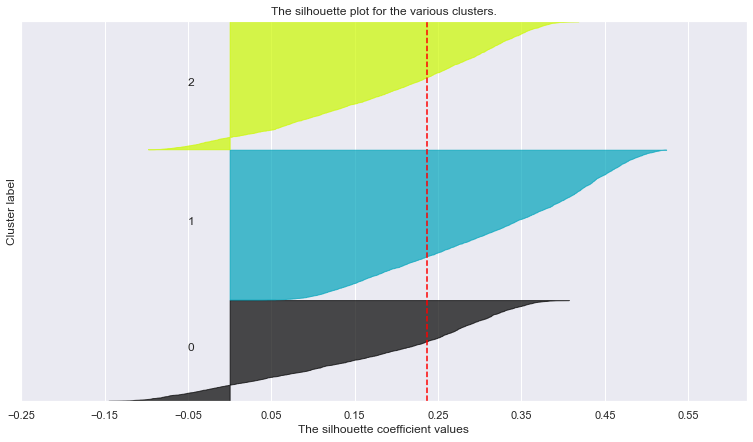

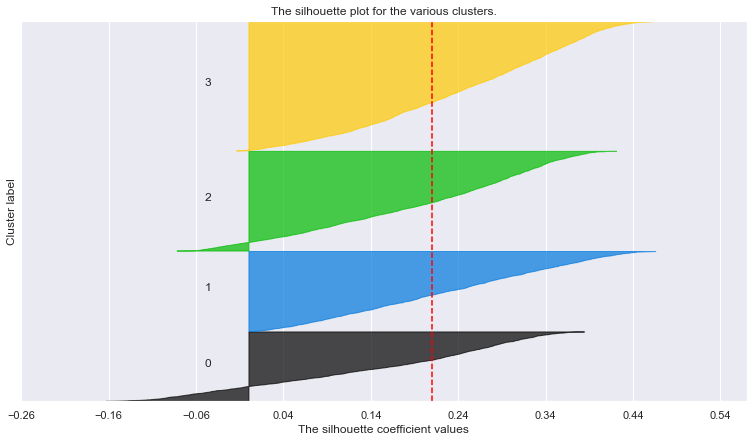

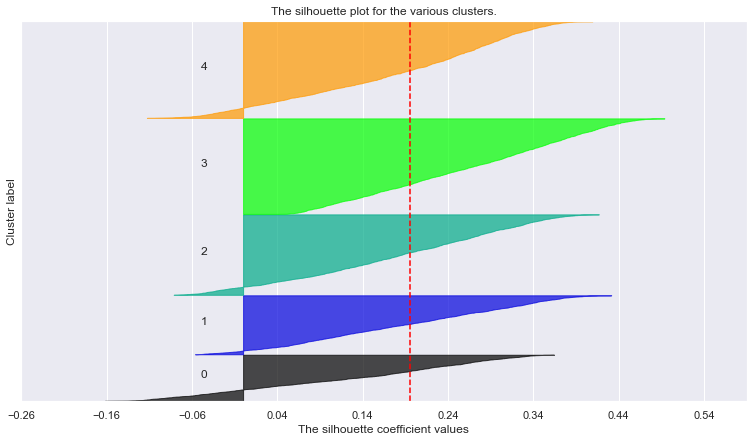

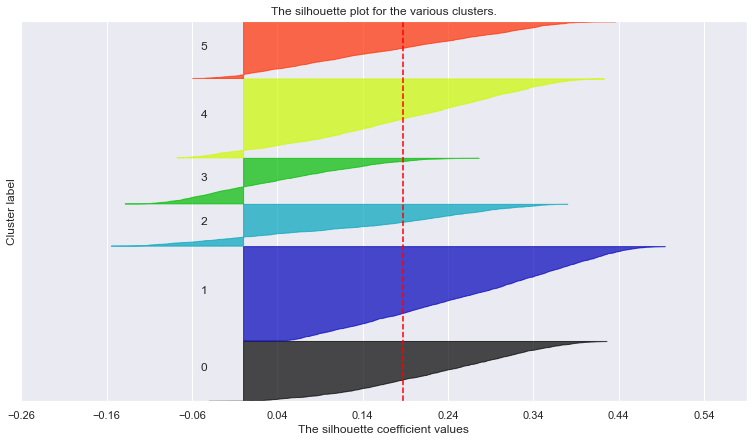

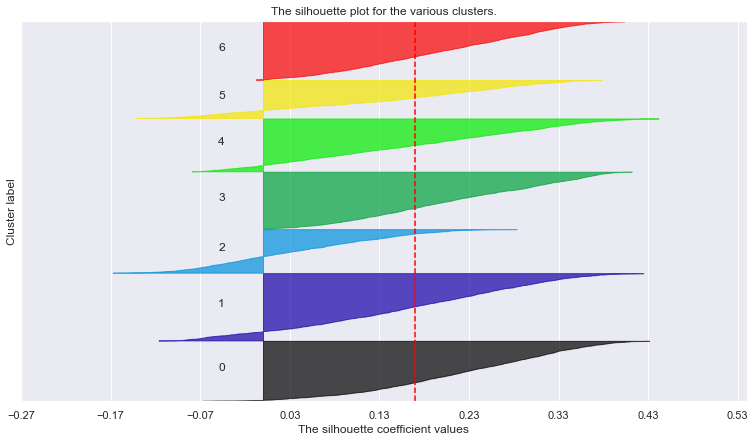

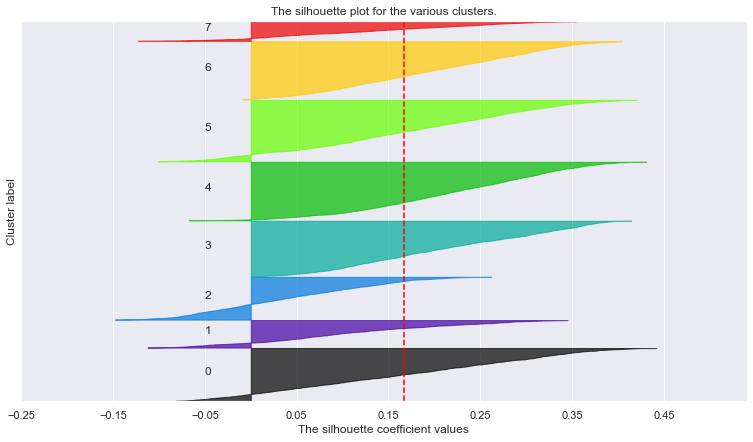

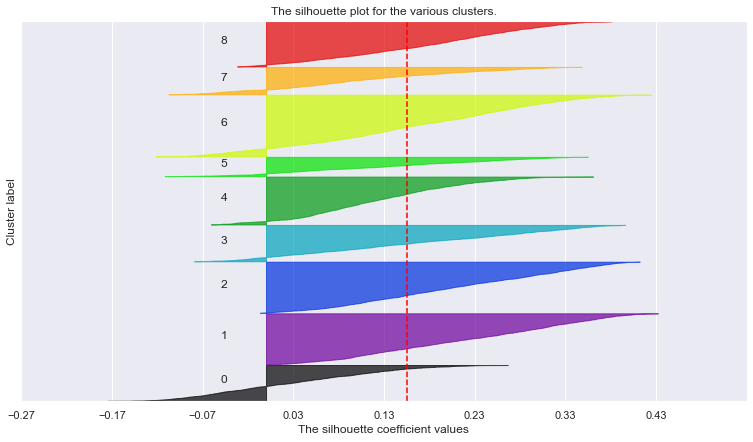

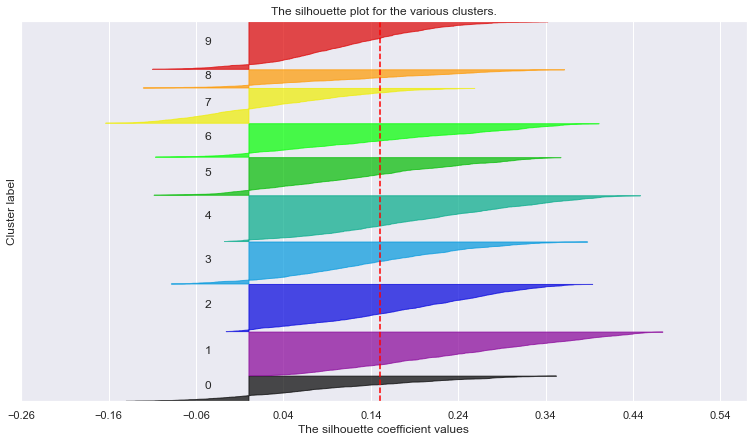

In [15]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df[metric_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg =  silhouette_score(df[metric_features], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values =  silhouette_samples(df[metric_features], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df[metric_features]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

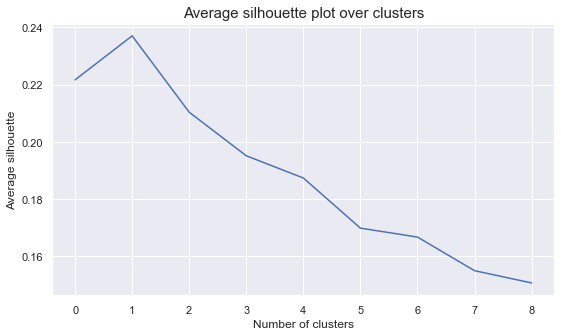

In [16]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

### Final KMeans clustering solution

In [24]:
# final cluster solution
number_clusters = 3
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df[metric_features])
km_labels

array([2, 2, 0, ..., 1, 2, 2])

In [25]:
# Characterizing the final clusters
df_concat = pd.concat((df, pd.Series(km_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

income       frq       rcn   clothes   kitchen  small_appliances  \
labels                                                                       
0      -1.046753 -0.846839  0.106507 -1.036292  0.812795          0.472976   
1      -0.194692 -0.335311 -0.009968  0.891570 -0.578927         -0.635109   
2       1.052418  1.059654 -0.072209 -0.227987  0.037861          0.371294   

            toys  house_keeping  per_net_purchase  spent_online  ...  \
labels                                                           ...   
0       0.817424       0.835083          0.697810     -0.769234  ...   
1      -0.585195      -0.563728          0.409679     -0.068841  ...   
2       0.041556       0.002507         -1.029376      0.686459  ...   

        x1_Widow      x2_M    x3_1.0  x4_Kind of OK  x4_Meh...  x4_OK nice!  \
labels                                                                        
0       0.008948  0.652748  0.842778       0.328504   0.334470     0.325096   
1       0.024355  0.640115  0.936676       0.298567   0.285100     0.349857   
2       0.110403  0.640268  0.360738       0.080537   0.087584     0.463423   

        x4_Take my money!!       PC0       PC1       PC2  
labels                                                    
0                 0.001278 -2.480245  0.110876  0.043692  
1                 0.062178  0.660500 -1.437224  0.071740  
2                 0.368456  1.179863  1.595868 -0.118429  

[3 rows x 27 columns]

In [27]:
df_concat.groupby('labels').size()
#if you get a group with one label, then you can remove these, they are outliers


labels
0    2347
1    3490
2    2980
dtype: int64

In [ ]:
#You can use your non-metric features for interpretation, 
#even if you did not use them for clustering

### How can we combine the 2 algorithms?

## Exercise:
**Apply Hierarchical Clustering and K-means on the Principal Components.**

Choose the appropriate parameters and number of clusters for each algorithm and interpret each cluster based on the Principal Components interpretation:

In [25]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var()*(df.shape[0]-1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        
        #get cluster labels
        hclabels = cluster.fit_predict(df) 
        
        # concat df with labels
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  
        
        # compute ssw for each cluster labels
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  
        
        # Obtain SSB. Remember: SST = SSW + SSB
        ssb =  sst-np.sum(ssw_labels)
        
        # append the R2 of the given cluster solution
        r2.append(ssb/sst)
        
    return np.array(r2)

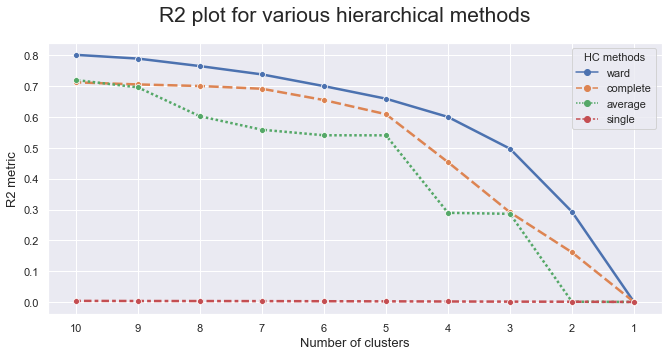

In [26]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]

# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack(
    [
        get_r2_hc(df[pc_features], link, max_nclus, min_nclus=1, dist="euclidean")
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [27]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = "ward"
distance = "euclidean"

# Define the clusterer
hclust = AgglomerativeClustering(distance_threshold=0,n_clusters=None, linkage=linkage, affinity=distance)
hclust.fit_predict(df[pc_features])

array([7923, 6285, 7894, ...,    3,    1,    0], dtype=int64)

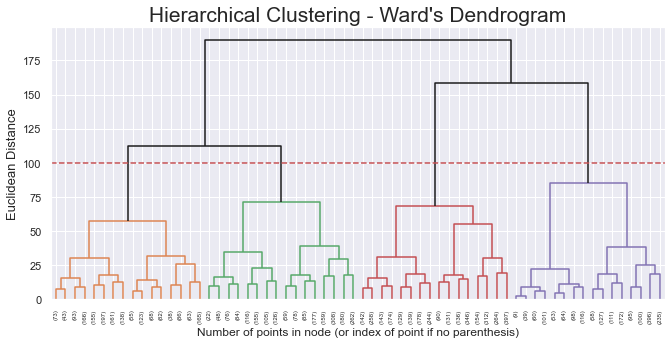

In [28]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [ ]:
#now that we have our number of clusters, lets apply that to a kmeans algorithm 

In [29]:
# final cluster solution
number_clusters = 4
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df[pc_features])
km_labels

array([1, 1, 0, ..., 3, 1, 1])

In [30]:
df_concat = pd.concat((df, pd.Series(km_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

income       frq       rcn   clothes   kitchen  small_appliances  \
labels                                                                       
0      -1.134336 -0.827742  0.002624 -1.384959  1.415021          0.091585   
1       1.088149  1.074881 -0.045267 -0.368255  0.095127          0.523251   
2       0.218481  0.172859 -0.154241  1.159693 -0.643274         -1.009659   
3      -0.706265 -0.809876  0.187111  0.013883 -0.234017          0.363087   

            toys  house_keeping  per_net_purchase  spent_online  ...  \
labels                                                           ...   
0       1.405942       1.412863          0.641474     -0.762902  ...   
1       0.105666       0.061911         -1.133885      0.566586  ...   
2      -0.659180      -0.628771          0.198906      0.566287  ...   
3      -0.225138      -0.212983          0.621176     -0.697857  ...   

        x1_Widow      x2_M    x3_1.0  x4_Kind of OK  x4_Meh...  x4_OK nice!  \
labels                                                                        
0       0.015825  0.661643  0.776187       0.321778   0.349661     0.312735   
1       0.113016  0.640686  0.308652       0.082619   0.086906     0.461029   
2       0.040946  0.639510  0.878430       0.233432   0.231321     0.380751   
3       0.010568  0.640705  0.946771       0.336986   0.315460     0.338552   

        x4_Take my money!!       PC0       PC1       PC2  
labels                                                    
0                 0.005275 -3.122312  0.627317  0.823909  
1                 0.369447  1.042102  1.790795 -0.248188  
2                 0.152385  1.555032 -1.160308  0.548810  
3                 0.000783 -0.866771 -1.048477 -0.687518  

[4 rows x 27 columns]